In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import os
import random

In [2]:
gpus=tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()
images=np.concatenate([x_train,x_test])
labels=np.concatenate([y_train,y_test])
images=(images/255).astype('float32')
labels=np.expand_dims(labels,axis=1)

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
num_classes=10
num_channels=1
latent_dim=128
batch_size=200

In [5]:
def show_images(images,label):
    if len(images.shape)==4:
        images=np.squeeze(images)
    if len(label.shape)==2:
        label=np.squeeze(label)
    fig=plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for idx in range(images.shape[0]):
        plt.subplot(4,8,idx+1)
        plt.imshow(images[idx],cmap=plt.cm.YlOrBr)
        plt.title(label[idx])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def show_generated_images():
    labels=np.random.randint(0,10,(32,1))
    noise=np.random.randn(32,latent_dim,1)
    fake_images=cgan_generator.predict([noise,labels],verbose=0)
    show_images(fake_images,labels)

In [6]:
train_data=tf.data.Dataset.from_tensor_slices((images,labels))
train_data=train_data.cache()
train_data=train_data.shuffle(images.shape[0])
train_data=train_data.batch(200)
train_data=train_data.prefetch(100)

In [7]:
train_iterator=train_data.as_numpy_iterator()

In [9]:
images,labels=train_iterator.next()
images.shape,labels.shape,images.max(),images.min()

((200, 28, 28), (200, 1), 1.0, 0.0)

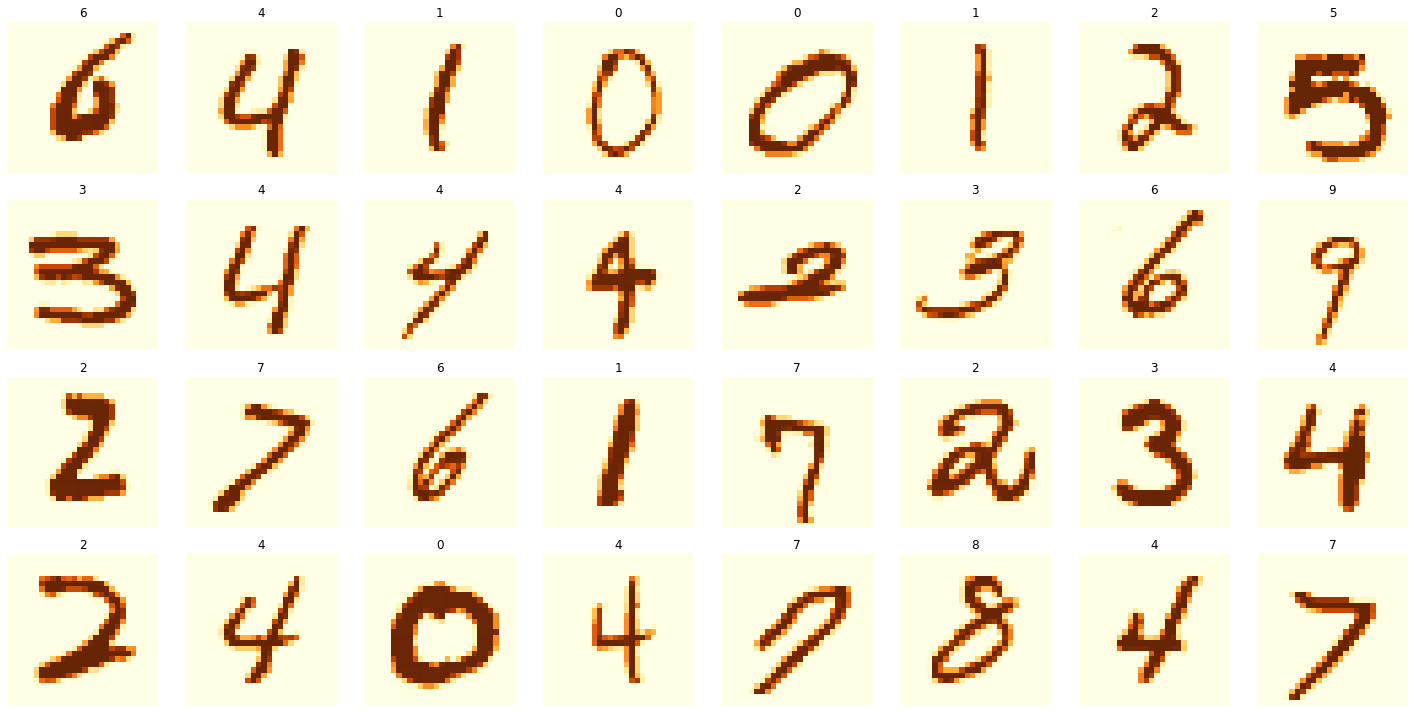

In [10]:
images,labels=train_iterator.next()
show_images(images[:32],labels[:32])

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU,Dropout,Conv2DTranspose,BatchNormalization,Multiply,Embedding,Concatenate
from tensorflow.keras import Input,Model

In [9]:
def build_generator(latent_dim):
    model=Sequential()

    model.add(Dense(7*7*32,input_shape=(latent_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(.2))
    model.add(Reshape((7,7,32)))

    model.add(Conv2DTranspose(32,(4,4),2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(.2))

    model.add(Conv2DTranspose(1,(4,4),2,padding='same',activation='sigmoid'))

    return model

In [10]:
generator=build_generator(latent_dim)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1568)              202272    
                                                                 
 batch_normalization (BatchN  (None, 1568)             6272      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1568)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       16416     
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       1

In [11]:
from tensorflow.keras.utils import plot_model

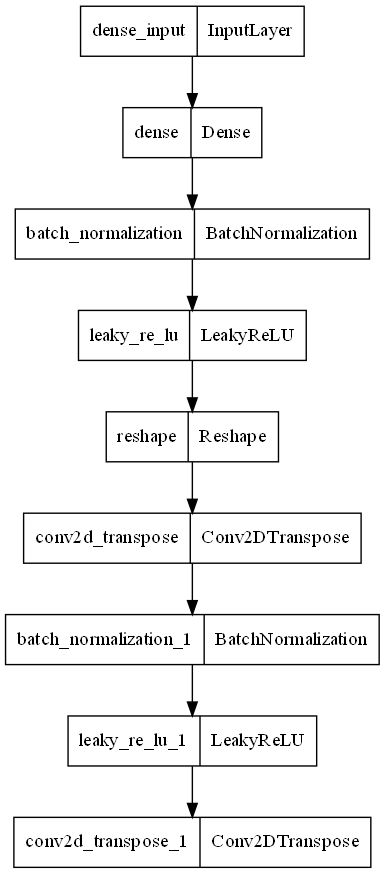

In [12]:
plot_model(generator,to_file=os.path.join('architecture','generator.png'),dpi=100)

In [13]:
def build_cgan_generator(latent_dim):
    noise=Input(shape=(latent_dim,),name='Noise_Input')
    label=Input(shape=(1,),dtype=tf.int32,name='label_Input')
    labelEmbedding=Embedding(num_classes,latent_dim)(label)
    labelEmbedding=Flatten()(labelEmbedding)
    combined=Multiply()([noise,labelEmbedding])
    conditionedImg=generator(combined)

    model=Model(inputs=[noise,label],outputs=conditionedImg,name='CGAN_generator')
    
    return model

In [14]:
def build_discriminator():
    model=Sequential()

    model.add(Conv2D(64,(4,4),1,padding='same',input_shape=(28,28,1+num_channels)))
    model.add(LeakyReLU(.2))

    model.add(Conv2D(64,(4,4),2,padding='same'))
    model.add(LeakyReLU(.2))

    model.add(Flatten())

    model.add(Dense(1,activation='sigmoid'))
    return model

In [15]:
discriminator=build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        2112      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        65600     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 12545     
                                                                 
Total params: 80,257
Trainable params: 80,257
Non-trai

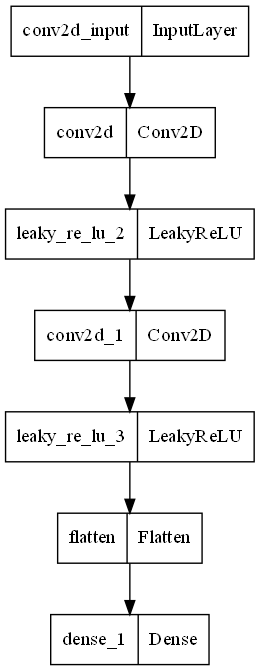

In [16]:
plot_model(discriminator,to_file=os.path.join('architecture','discriminator.png'),dpi=100)

In [17]:
def build_cgan_discriminator():
    image=Input(shape=(28,28,1),name='Image_Input')
    label=Input(shape=(1,),dtype=tf.int32,name='label_Input')
    labelEmbedding=Embedding(num_classes,28*28)(label)
    labelEmbedding=Flatten()(labelEmbedding)
    labelEmbedding=Reshape((28,28,1))(labelEmbedding)
    combined=Concatenate()([image,labelEmbedding])
    output=discriminator(combined)

    model=Model(inputs=[image,label],outputs=output,name='CGAN_discriminator')
    return model

In [18]:
cgan_generator=build_cgan_generator(latent_dim)
print(cgan_generator.summary())
cgan_discriminator=build_cgan_discriminator()
print(cgan_discriminator.summary())

Model: "CGAN_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 128)       1280        ['label_Input[0][0]']            
                                                                                                  
 Noise_Input (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 128)          0           ['embedding[0][0]']              
                                                                                     

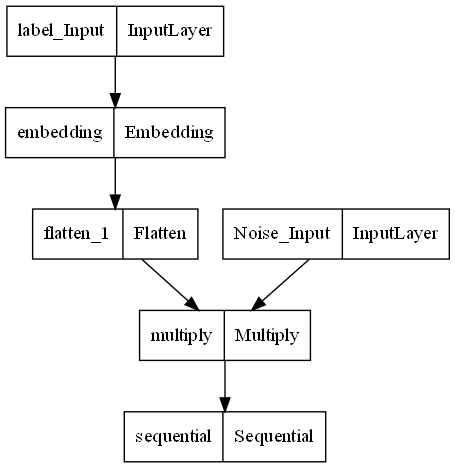

In [19]:
plot_model(cgan_generator,to_file=os.path.join('architecture','cgan_generator.png'),dpi=100)

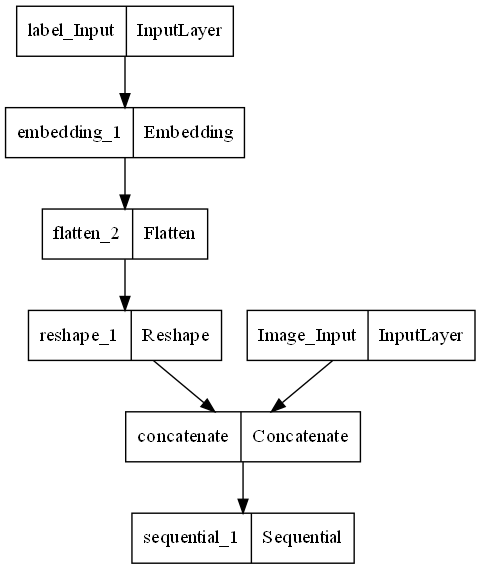

In [20]:
plot_model(cgan_discriminator,to_file=os.path.join('architecture','cgan_discriminator.png'),dpi=100)

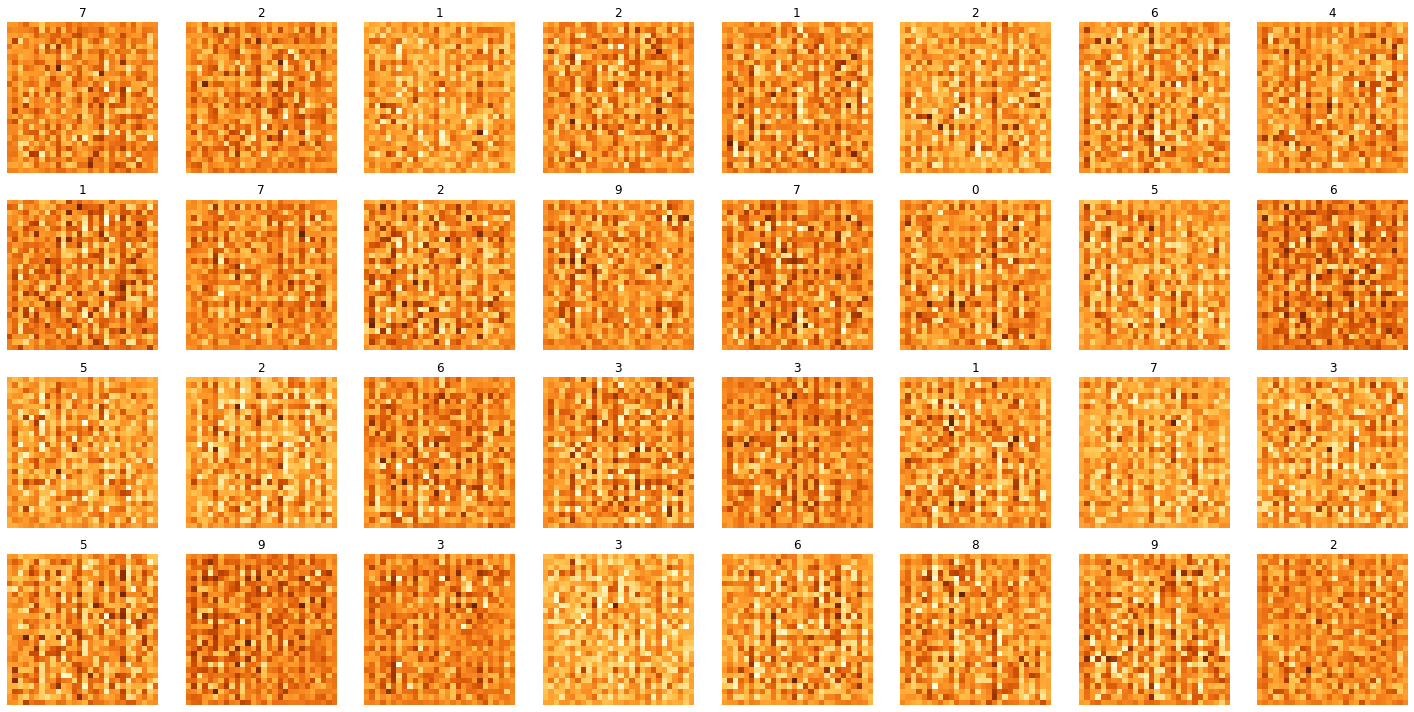

In [21]:
noise=tf.random.normal((32,latent_dim,1))
labels=np.random.randint(0,10,size=(32,1))
show_images(cgan_generator([noise,labels]),labels)

In [60]:
real_images,labels=train_iterator.next()
real_images=real_images[:3]
labels=labels[:3]
noise=tf.random.normal((3,latent_dim,1))
fake_images=cgan_generator([noise,labels])
cgan_discriminator([fake_images,labels]),cgan_discriminator([real_images,labels])

(<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.5115395],
        [0.5034734],
        [0.5056636]], dtype=float32)>,
 <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.5080116 ],
        [0.50491494],
        [0.5089775 ]], dtype=float32)>)

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [23]:
cgan_generator_opt=Adam(2e-4)
cgan_discriminator_opt=Adam(1e-4)

cgan_generator_loss=BinaryCrossentropy()
cgan_discriminator_loss=BinaryCrossentropy()

In [24]:
from tensorflow.keras import Model

In [25]:
class ConditionalGan(Model):
    def __init__(self,cgan_generator,cgan_discriminator,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.cgan_generator=cgan_generator
        self.cgan_discriminator=cgan_discriminator
    
    def compile(self,cgan_generator_opt,cgan_discriminator_opt,cgan_generator_loss,cgan_discriminator_loss,*args,**kwargs):
        super().compile(*args,**kwargs)
        self.cgan_generator_opt=cgan_generator_opt
        self.cgan_discriminator_opt=cgan_discriminator_opt
        self.cgan_generator_loss=cgan_generator_loss
        self.cgan_discriminator_loss=cgan_discriminator_loss

    def train_step(self,batch):
        real_images,labels=batch
        fake_images=self.cgan_generator([tf.random.normal((batch_size,latent_dim,1)),labels],training=False)

        with tf.GradientTape() as d_tape:
            yhat_real=self.cgan_discriminator([real_images,labels],training=True)
            yhat_fake=self.cgan_discriminator([fake_images,labels],training=True)
            yhat_realfake=tf.concat([yhat_real,yhat_fake],axis=0)
            
            y_realfake=tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.cgan_discriminator_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.cgan_discriminator.trainable_variables) 
        self.cgan_discriminator_opt.apply_gradients(zip(dgrad, self.cgan_discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            gen_images = self.cgan_generator([tf.random.normal((batch_size,latent_dim,1)),labels], training=True)
            predicted_labels = self.cgan_discriminator([gen_images,labels], training=False)

            total_g_loss = self.cgan_generator_loss(tf.zeros_like(predicted_labels), predicted_labels)
        
        ggrad = g_tape.gradient(total_g_loss, self.cgan_generator.trainable_variables)
        self.cgan_generator_opt.apply_gradients(zip(ggrad, self.cgan_generator.trainable_variables))

        return {'d_loss':total_d_loss,'g_loss':total_g_loss}

In [26]:
# ---------------- LOAD PRE-TRAINED MODEL ---------------------

generator=tf.keras.models.load_model(os.path.join('models','generator.h5'))
discriminator=tf.keras.models.load_model(os.path.join('models','discriminator.h5'))
cgan_generator=tf.keras.models.load_model(os.path.join('models','CGAN_generator.h5'))
cgan_discriminator=tf.keras.models.load_model(os.path.join('models','CGAN_discriminator.h5'))

In [27]:
conditionalgan=ConditionalGan(cgan_generator,cgan_discriminator)
conditionalgan.compile(cgan_generator_opt,cgan_discriminator_opt,cgan_generator_loss,cgan_discriminator_loss)

In [28]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import pandas as pd

In [29]:
class ModelMonitor(Callback):
    def __init__(self,num_images=1,latent_dim=latent_dim):
        self.num_images=num_images
        self.latent_dim=latent_dim
    
    def on_epoch_end(self,epoch,logs=tf.keras.callbacks.TensorBoard(log_dir='logs')):
        labels=np.random.randint(0,10,(self.num_images,1))
        generated_images=cgan_generator([tf.random.normal((self.num_images,latent_dim,1)),labels],training=False)
        generated_images=(generated_images*255)
        generated_images=tf.cast(generated_images,dtype=np.int32)
        for i in range(self.num_images):
            img=array_to_img(generated_images[i])
            img.save(os.path.join('generated',f'CGAN_generated-{epoch+1}.{i}.jpg'))

In [69]:
history=conditionalgan.fit(train_data,epochs=100,callbacks=[
    ModelMonitor(),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.ModelCheckpoint('temp/checkpoint',save_weights_only=True,monitor='g_loss',save_best_only=True)
])

Epoch 1/100
350/350 [==============================] - 16s 40ms/step - d_loss: 0.6711 - g_loss: 0.7689
Epoch 2/100
350/350 [==============================] - 14s 41ms/step - d_loss: 0.6908 - g_loss: 0.8821
Epoch 3/100
350/350 [==============================] - 14s 41ms/step - d_loss: 0.6096 - g_loss: 0.9176
Epoch 4/100
350/350 [==============================] - 14s 41ms/step - d_loss: 0.6087 - g_loss: 1.0203
Epoch 5/100
350/350 [==============================] - 15s 41ms/step - d_loss: 0.6779 - g_loss: 0.7854
Epoch 6/100
350/350 [==============================] - 14s 41ms/step - d_loss: 0.6763 - g_loss: 0.7582
Epoch 7/100
350/350 [==============================] - 14s 41ms/step - d_loss: 0.6742 - g_loss: 0.7462
Epoch 8/100
350/350 [==============================] - 14s 41ms/step - d_loss: 0.6545 - g_loss: 0.7615
Epoch 9/100
350/350 [==============================] - 14s 41ms/step - d_loss: 0.6500 - g_loss: 0.7675
Epoch 10/100
350/350 [==============================] - 14s 41ms/step - d

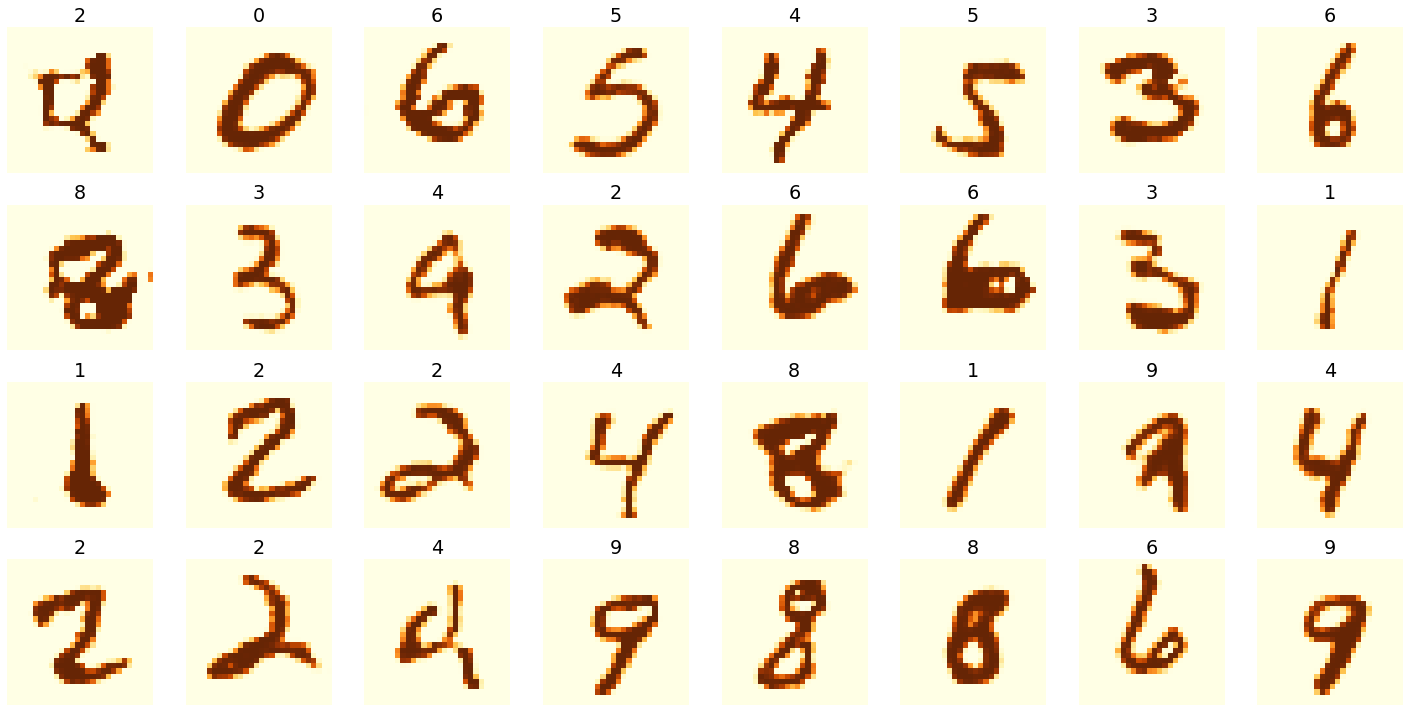

In [44]:
show_generated_images()

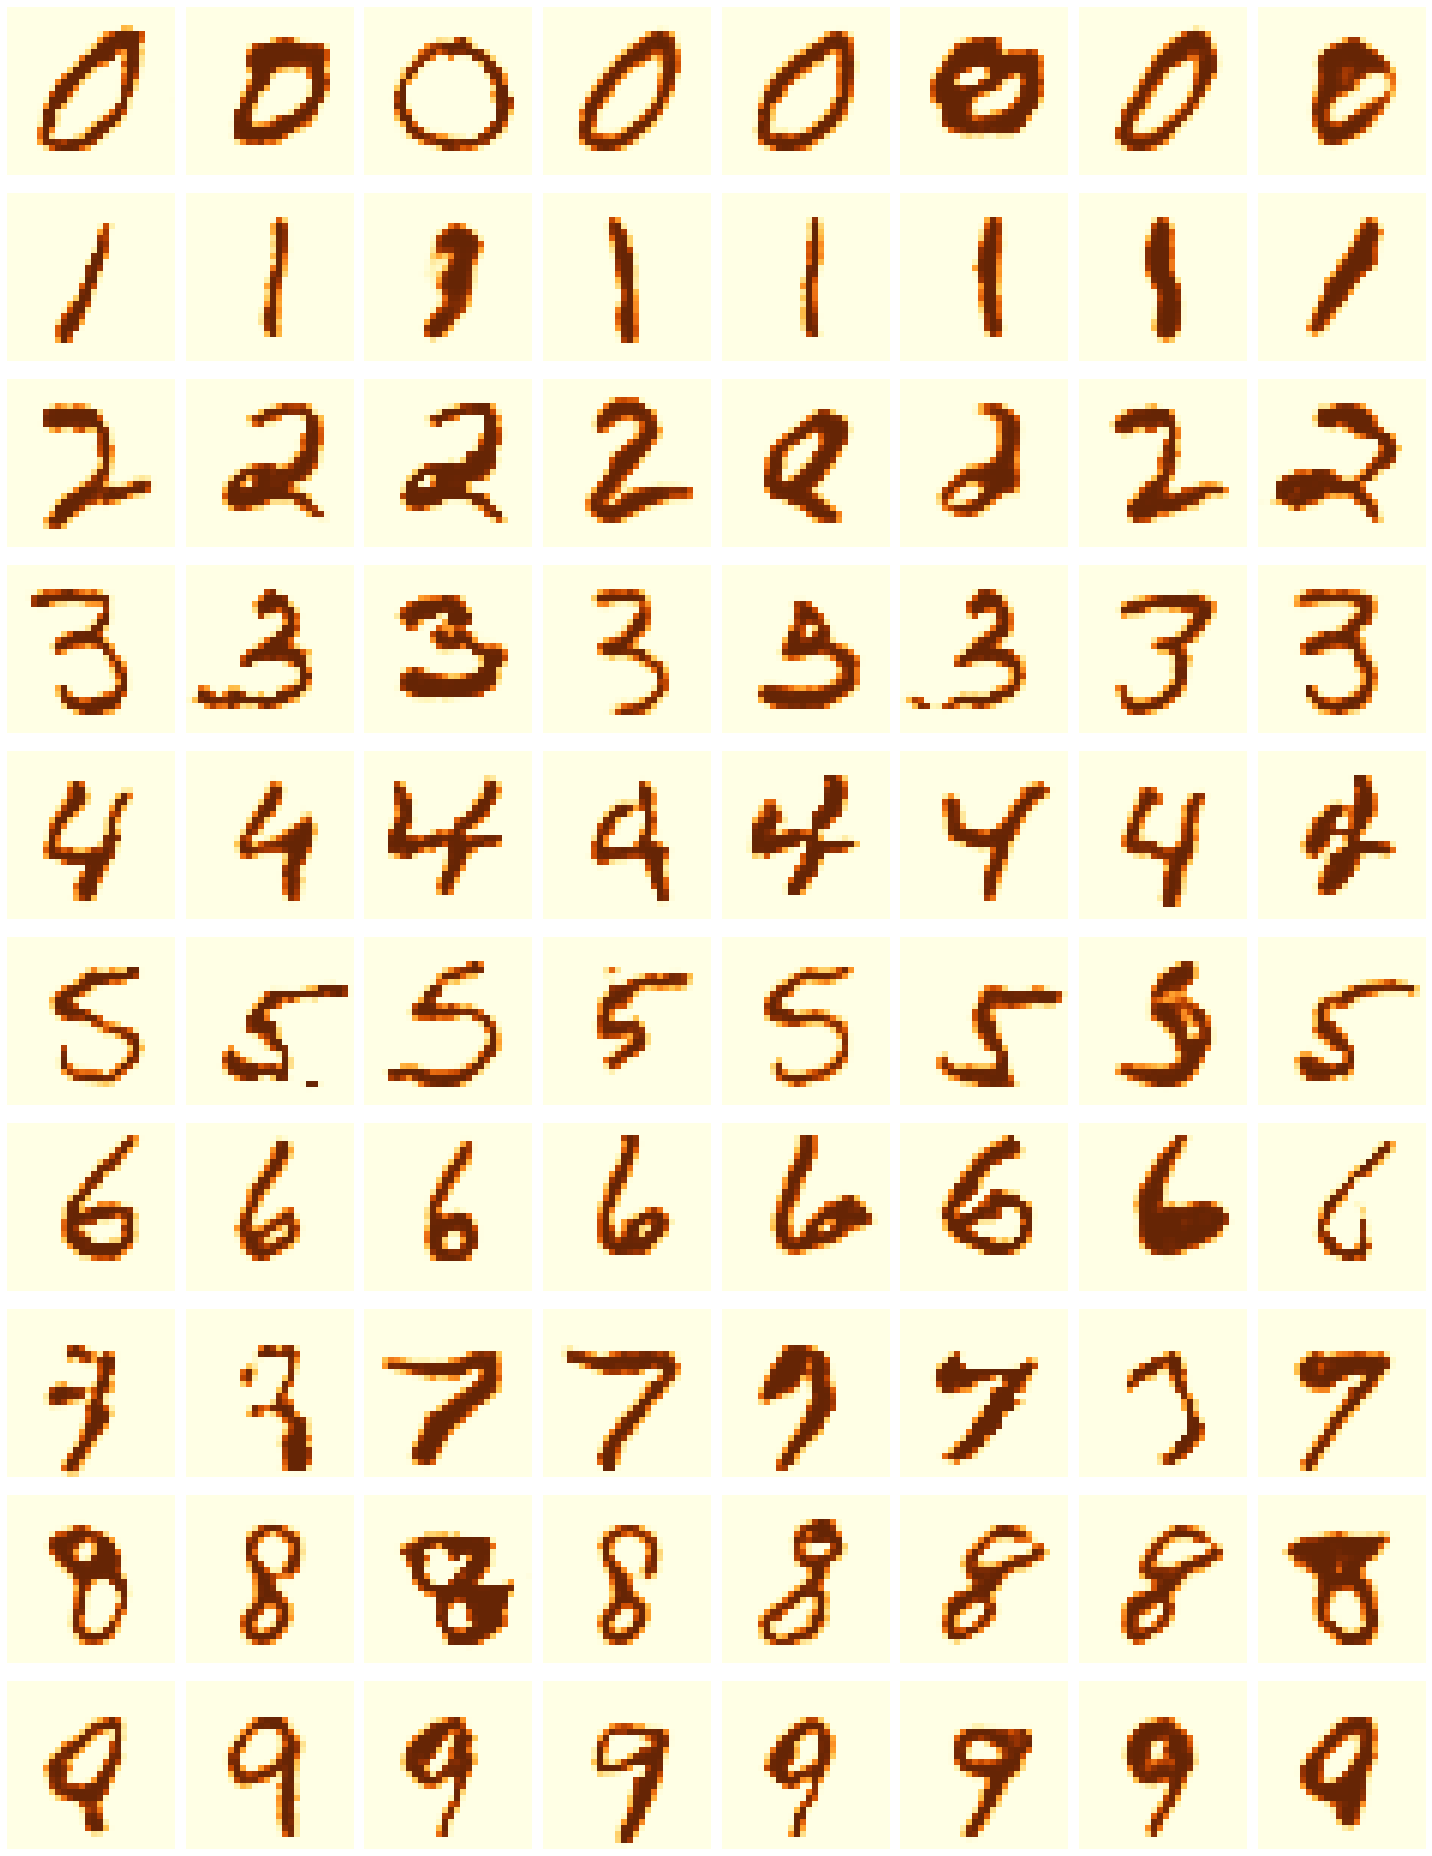

In [31]:
labels=np.random.randint(0,1,(8,1))
labels=np.concatenate([labels,np.random.randint(1,2,(8,1)),np.random.randint(2,3,(8,1)),np.random.randint(3,4,(8,1)),np.random.randint(4,5,(8,1)),np.random.randint(5,6,(8,1))])
labels=np.concatenate([labels,np.random.randint(6,7,(8,1)),np.random.randint(7,8,(8,1)),np.random.randint(8,9,(8,1)),np.random.randint(9,10,(8,1))])
noise=np.random.randn(80,latent_dim,1)
fake_images=np.squeeze(cgan_generator.predict([noise,labels],verbose=0))
fig=plt.figure()
fig.set_figwidth(20)
fig.set_figheight(26)
for idx in range(fake_images.shape[0]):
    plt.subplot(10,8,idx+1)
    plt.imshow(fake_images[idx],cmap=plt.cm.YlOrBr)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [72]:
# ---------- CAUTION -------------

# df=pd.DataFrame(history.history)
# df.to_csv('CGAN_model_loss.csv',index=False)

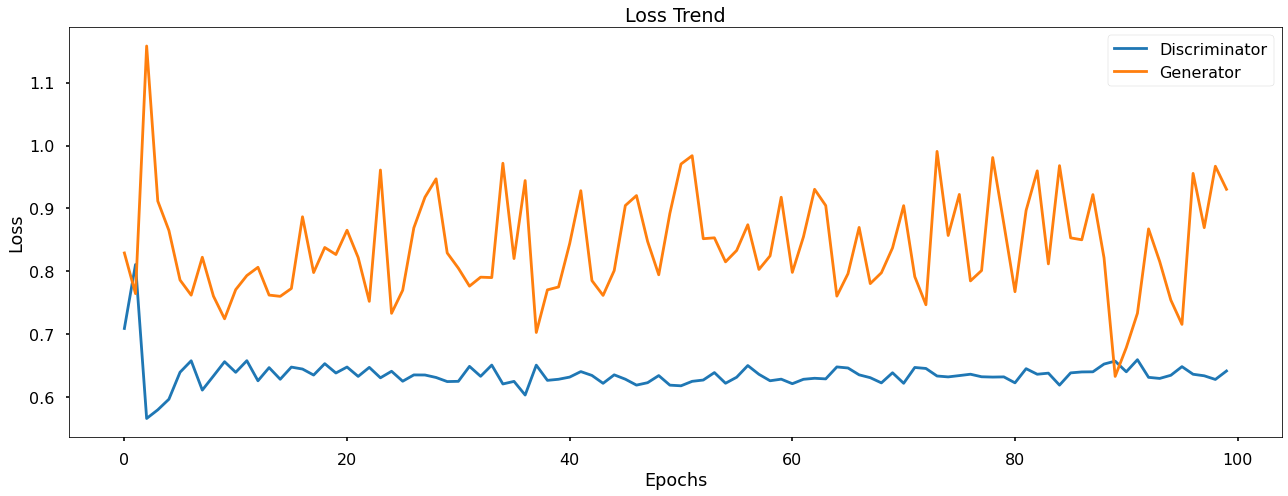

In [32]:
df=pd.read_csv('CGAN_model_loss.csv')
plt.style.use('seaborn-poster')
plt.figure(figsize=(18,7))
plt.plot(df['d_loss'],label='Discriminator')
plt.plot(df['g_loss'],label='Generator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
# # # ------------!!!  CAUTION  !!!---------------------

# if not os.path.exists('metadata'):
#     os.mkdir('metadata')
# generator.save('./metadata/')
# discriminator.save('./metadata/')
# if not os.path.exists('models'):
#     os.mkdir('models')
# tf.keras.models.save_model(generator,os.path.join('models','generator.h5'))
# tf.keras.models.save_model(discriminator,os.path.join('models','discriminator.h5'))
# tf.keras.models.save_model(cgan_generator,os.path.join('models','CGAN_generator.h5'))
# tf.keras.models.save_model(cgan_discriminator,os.path.join('models','CGAN_discriminator.h5'))